In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import xarray as xr

from jaxparrow.tools import compute_coriolis_factor, compute_spatial_step
from jaxparrow import cyclogeostrophy, geostrophy

%reload_ext autoreload
%autoreload 2

# Input data

In this example, we use NEMO model outputs (SSH and velocities), stored in several netCDF files.
Therefore, data is located on a C-grid.

In [2]:
dir_data = "data"
name_mask = "mask_eNATL60MEDWEST_3.6.nc"
name_coord = "coordinates_eNATL60MEDWEST.nc"
name_ssh = "eNATL60MEDWEST-BLB002_y2009m07d01.1h_sossheig.nc"
name_u = "eNATL60MEDWEST-BLB002_y2009m07d01.1h_sozocrtx.nc"
name_v = "eNATL60MEDWEST-BLB002_y2009m07d01.1h_somecrty.nc"

#### Alboran sea

The original simulation covers a large mediterranean area that we crop to the Alboran sea.

In [3]:
min_lon = -5.5
max_lon = -1
min_lat = 35
max_lat = 36.9

In [4]:
ds_coord = xr.open_dataset(os.path.join(dir_data, name_coord))

alboran_mask = np.logical_and(np.logical_and(ds_coord.nav_lon >= min_lon, ds_coord.nav_lon <= max_lon),
                              np.logical_and(ds_coord.nav_lat >= min_lat, ds_coord.nav_lat <= max_lat))

ds_coord = ds_coord.set_coords(["nav_lon", "nav_lat"])
ds_coord = ds_coord.where(alboran_mask, drop=True)
lon = ds_coord.nav_lon.values
lat = ds_coord.nav_lat.values

ds_mask = xr.open_dataset(os.path.join(dir_data, name_mask)).set_coords(["nav_lon", "nav_lat"])
ds_mask = ds_mask.where(alboran_mask, drop=True)
mask_ssh = ds_mask.tmask[0,0].values
mask_u = ds_mask.umask[0,0].values
mask_v = ds_mask.vmask[0,0].values

ds_ssh = xr.open_dataset(os.path.join(dir_data, name_ssh)).set_coords(["nav_lon", "nav_lat"])
ds_ssh = ds_ssh.where(alboran_mask, drop=True)
lon_ssh = ds_ssh.nav_lon.values
lat_ssh = ds_ssh.nav_lat.values
ssh = ds_ssh.sossheig[0].values

ds_u = xr.open_dataset(os.path.join(dir_data, name_u)).set_coords(["nav_lon", "nav_lat"])
ds_u = ds_u.where(alboran_mask, drop=True)
lon_u = ds_u.nav_lon.values
lat_u = ds_u.nav_lat.values
uvel = ds_u.sozocrtx[0].values

ds_v = xr.open_dataset(os.path.join(dir_data, name_v)).set_coords(["nav_lon", "nav_lat"])
ds_v = ds_v.where(alboran_mask, drop=True)
lon_v = ds_v.nav_lon.values
lat_v = ds_v.nav_lat.values
vvel = ds_v.somecrty[0].values

We use `masked_array` to restrict the domain to the marine area.

In [5]:
mask_u = 1 - mask_u
mask_v = 1 - mask_v
mask_ssh = 1 - mask_ssh

In [6]:
uvel = ma.masked_array(uvel, mask_u)
vvel = ma.masked_array(vvel, mask_v)
ssh = ma.masked_array(ssh, mask_ssh)

In [7]:
lon_u = ma.masked_array(lon_u, mask_u)
lat_u = ma.masked_array(lat_u, mask_u)
lon_v = ma.masked_array(lon_v, mask_v)
lat_v = ma.masked_array(lat_v, mask_v)
lon_ssh = ma.masked_array(lon_ssh, mask_ssh)
lat_ssh = ma.masked_array(lat_ssh, mask_ssh)

#### Visualising SSH and currents

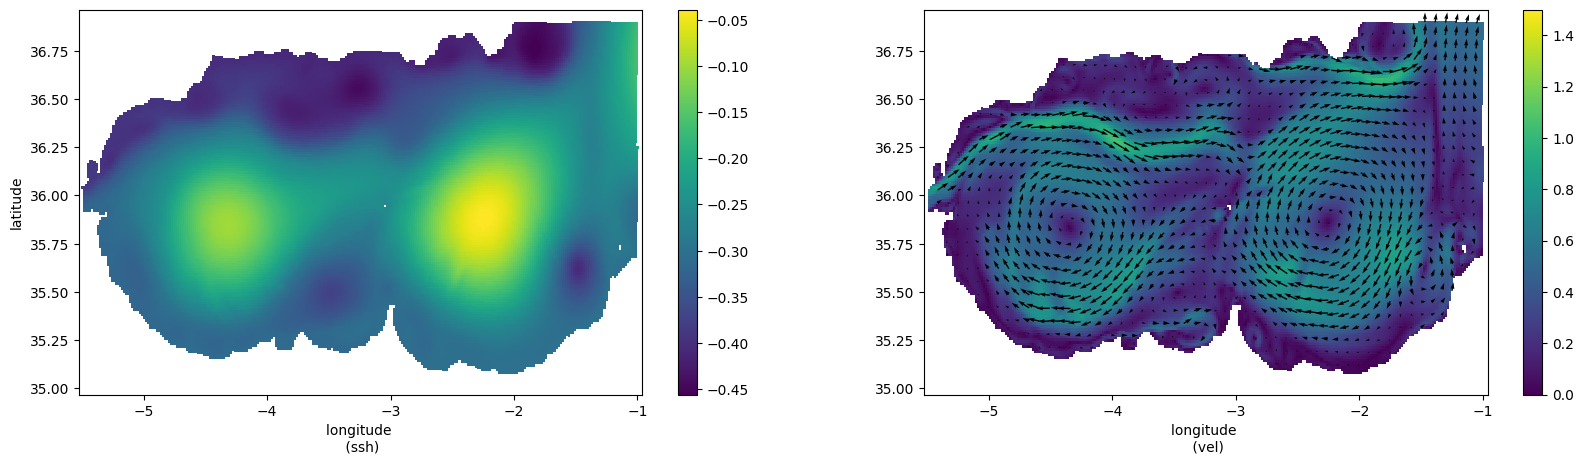

In [8]:
vmax = 1.5
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_xlabel("longitude \n (ssh)")
ax2.set_xlabel("longitude \n (vel)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, ssh, shading="auto")
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, np.sqrt(uvel**2 + vvel**2), shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax2)
quiver_step = 5
ax2.quiver(lon[::quiver_step, ::quiver_step], lat[::quiver_step, ::quiver_step], 
           uvel[::quiver_step, ::quiver_step], vvel[::quiver_step, ::quiver_step])
plt.show()

#### Compute spatial steps

The netCDF files we use as input do not contain the spatial steps required to compute derivatives later.
The sub-module `tools` provides the utility function `compute_spatial_step` to compute them from our grids.

In [9]:
dx_ssh, dy_ssh = compute_spatial_step(lat_ssh, lon_ssh)
dx_u, dy_u = compute_spatial_step(lat_u, lon_u)
dx_v, dy_v = compute_spatial_step(lat_v, lon_v)

#### Coriolis factor

Estimating the velocities also involve the Coriolis factor, which varies with the latitude.
The function `compute_coriolis_factor` from the sub-module `tools` might be used here.

In [10]:
coriolis_factor_ssh = compute_coriolis_factor(lat_ssh)
coriolis_factor_u = compute_coriolis_factor(lat_u)
coriolis_factor_v = compute_coriolis_factor(lat_v)

# Geostrophic balance

We estimate the geostrophic velocities using the `geostrophy` function, given the SSH, the spatial steps, and the coriolis factors.

In [11]:
u_geos, v_geos = geostrophy(ssh, dx_ssh, dy_ssh, coriolis_factor_u, coriolis_factor_v)

In [12]:
u_geos = ma.masked_array(u_geos, mask_u)
v_geos = ma.masked_array(v_geos, mask_v)

#### Comparison to NEMO's velocities

/tmp/ipykernel_28536/3301327445.py:9: RuntimeWarning: invalid value encountered in sqrt
  im = ax2.pcolormesh(lon, lat, np.sqrt(u_geos**2 + v_geos**2), shading="auto", vmin=0, vmax=vmax)
/tmp/ipykernel_28536/3301327445.py:18: RuntimeWarning: invalid value encountered in sqrt
  im = ax1.pcolormesh(lon, lat, np.sqrt(uvel**2 + vvel**2) - np.sqrt(u_geos**2 + v_geos**2), cmap="RdBu", shading="auto")
/tmp/ipykernel_28536/3301327445.py:20: RuntimeWarning: invalid value encountered in sqrt
  im = ax2.pcolormesh(lon, lat, (np.sqrt(uvel**2 + vvel**2) - np.sqrt(u_geos**2 + v_geos**2)) / np.sqrt(uvel**2 + vvel**2), cmap="RdBu", shading="auto", vmin=-1, vmax=1)


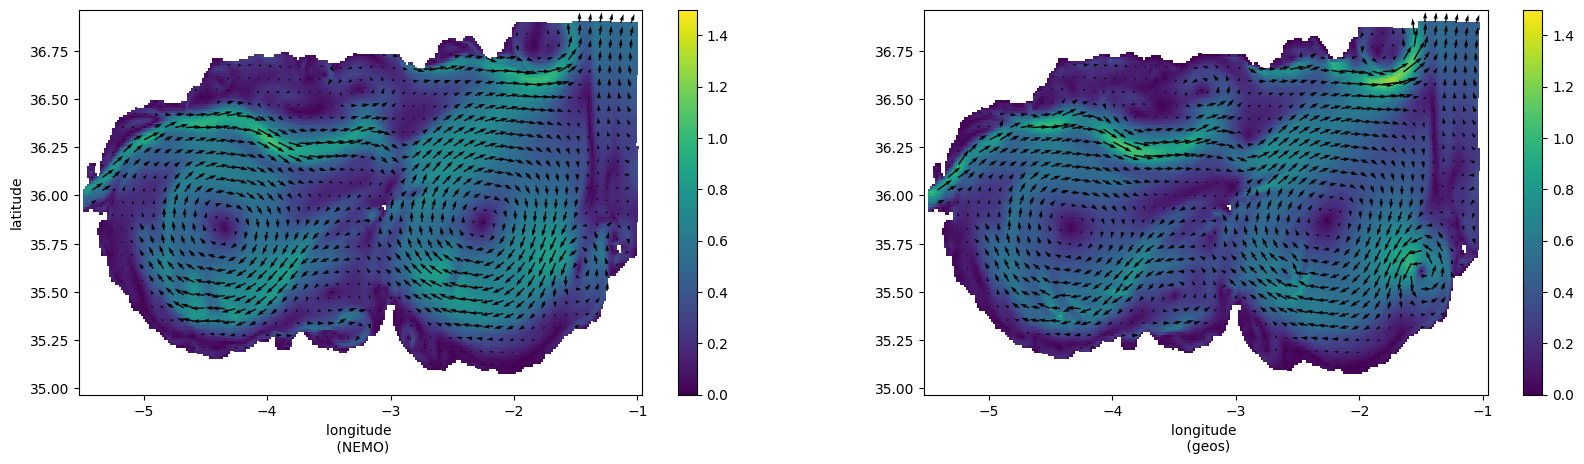

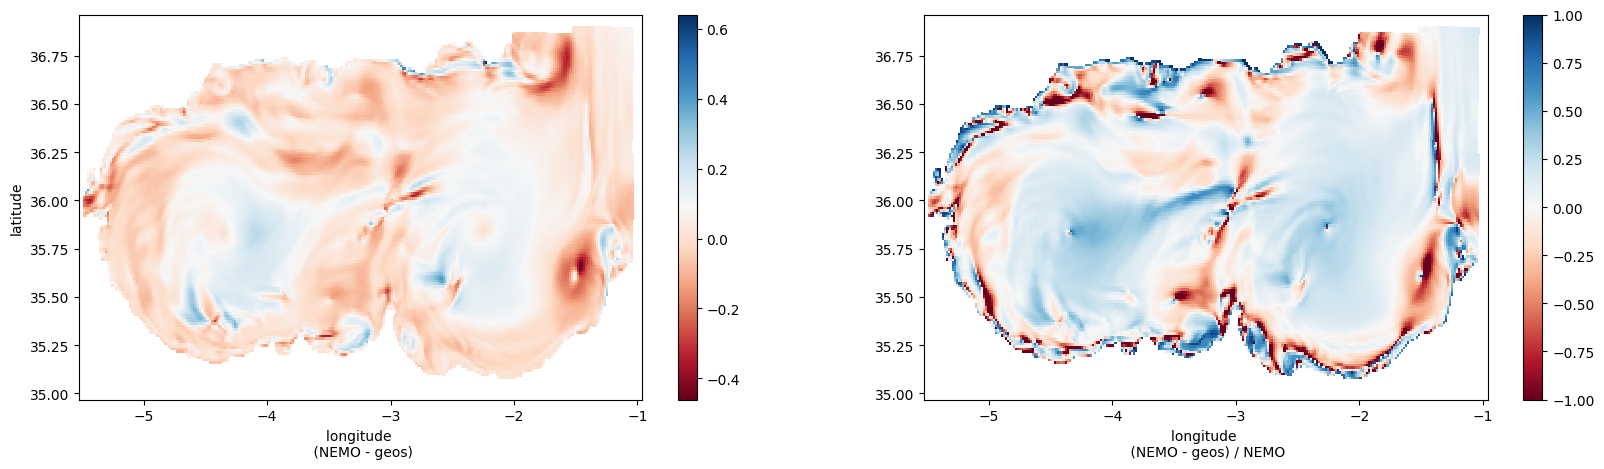

In [13]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_xlabel("longitude \n (NEMO)")
ax2.set_xlabel("longitude \n (geos)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, np.sqrt(uvel**2 + vvel**2), shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax1)
ax1.quiver(lon[::quiver_step, ::quiver_step], lat[::quiver_step, ::quiver_step], 
           uvel[::quiver_step, ::quiver_step], vvel[::quiver_step, ::quiver_step])
im = ax2.pcolormesh(lon, lat, np.sqrt(u_geos**2 + v_geos**2), shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax2)
ax2.quiver(lon[::quiver_step, ::quiver_step], lat[::quiver_step, ::quiver_step], 
           u_geos[::quiver_step, ::quiver_step], v_geos[::quiver_step, ::quiver_step])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_xlabel("longitude \n (NEMO - geos)")
ax2.set_xlabel("longitude \n (NEMO - geos) / NEMO")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, np.sqrt(uvel**2 + vvel**2) - np.sqrt(u_geos**2 + v_geos**2), cmap="RdBu", shading="auto")
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, (np.sqrt(uvel**2 + vvel**2) - np.sqrt(u_geos**2 + v_geos**2)) / np.sqrt(uvel**2 + vvel**2), cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

# Cyclogeostrophic balance

## Variational method

Cyclogeostrophic velocities are computed via the `cyclogeostrophy` function, using geostrophic velocities (here, the ones we previously computed), spatial steps, and the coriolis factors.

In [14]:
u_var, v_var = cyclogeostrophy(u_geos, v_geos, dx_u, dx_v, dy_u, dy_v, coriolis_factor_u, coriolis_factor_v)

2023-10-24 17:30:01.521506: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:276] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
100%|██████████| 2000/2000 [00:03<00:00, 544.41it/s] 


In [15]:
u_var = ma.masked_array(u_var, mask_u)
v_var = ma.masked_array(v_var, mask_v)

#### Comparison to NEMO's velocities

/tmp/ipykernel_28536/851051289.py:9: RuntimeWarning: invalid value encountered in sqrt
  im = ax2.pcolormesh(lon, lat, np.sqrt(u_var**2 + v_var**2), shading="auto", vmin=0, vmax=vmax)
/tmp/ipykernel_28536/851051289.py:18: RuntimeWarning: invalid value encountered in sqrt
  im = ax1.pcolormesh(lon, lat, np.sqrt(uvel**2 + vvel**2) - np.sqrt(u_var**2 + v_var**2), cmap="RdBu", shading="auto")
/tmp/ipykernel_28536/851051289.py:20: RuntimeWarning: invalid value encountered in sqrt
  im = ax2.pcolormesh(lon, lat, (np.sqrt(uvel**2 + vvel**2) - np.sqrt(u_var**2 + v_var**2)) / np.sqrt(uvel**2 + vvel**2), cmap="RdBu", shading="auto", vmin=-1, vmax=1)


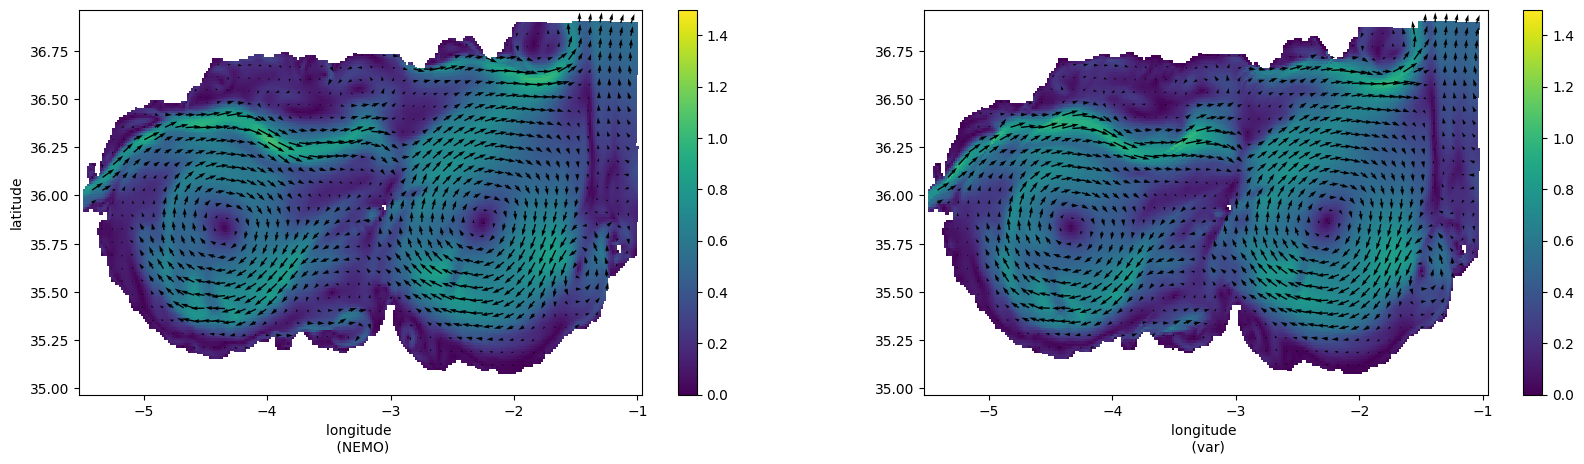

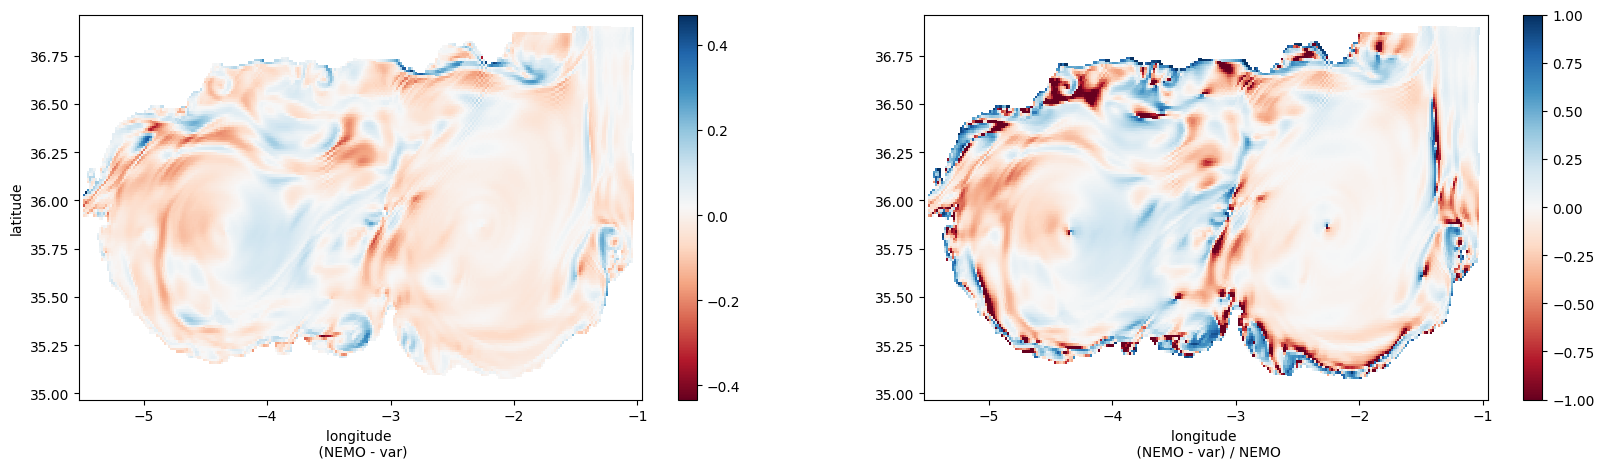

In [16]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_xlabel("longitude \n (NEMO)")
ax2.set_xlabel("longitude \n (var)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, np.sqrt(uvel**2 + vvel**2), shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax1)
ax1.quiver(lon[::quiver_step, ::quiver_step], lat[::quiver_step, ::quiver_step], 
           uvel[::quiver_step, ::quiver_step], vvel[::quiver_step, ::quiver_step])
im = ax2.pcolormesh(lon, lat, np.sqrt(u_var**2 + v_var**2), shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax2)
ax2.quiver(lon[::quiver_step, ::quiver_step], lat[::quiver_step, ::quiver_step], 
           u_var[::quiver_step, ::quiver_step], v_var[::quiver_step, ::quiver_step])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_xlabel("longitude \n (NEMO - var)")
ax2.set_xlabel("longitude \n (NEMO - var) / NEMO")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, np.sqrt(uvel**2 + vvel**2) - np.sqrt(u_var**2 + v_var**2), cmap="RdBu", shading="auto")
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, (np.sqrt(uvel**2 + vvel**2) - np.sqrt(u_var**2 + v_var**2)) / np.sqrt(uvel**2 + vvel**2), cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

## Penven method

We use the same function, but with the argument `method="penven"`. 

In [17]:
u_penven, v_penven = cyclogeostrophy(u_geos, v_geos, dx_u, dx_v, dy_u, dy_v, coriolis_factor_u, coriolis_factor_v, method="penven")

100%|██████████| 100/100 [00:00<00:00, 213.83it/s]


In [18]:
u_penven = ma.masked_array(u_penven, mask_u)
v_penven = ma.masked_array(v_penven, mask_v)

#### Comparison to NEMO's velocities

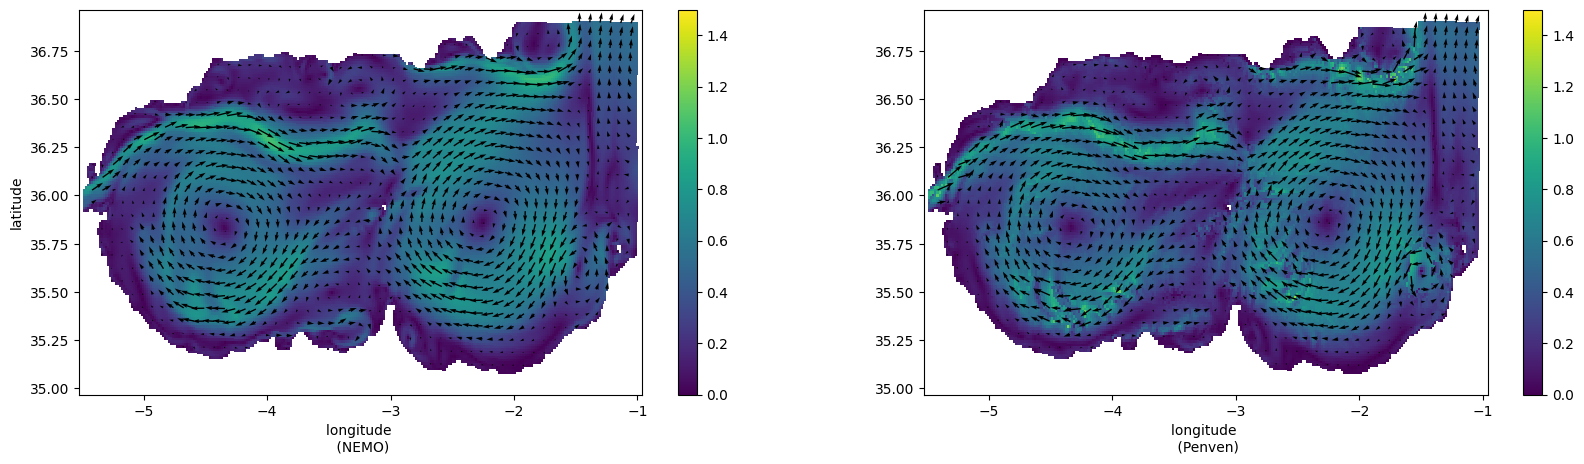

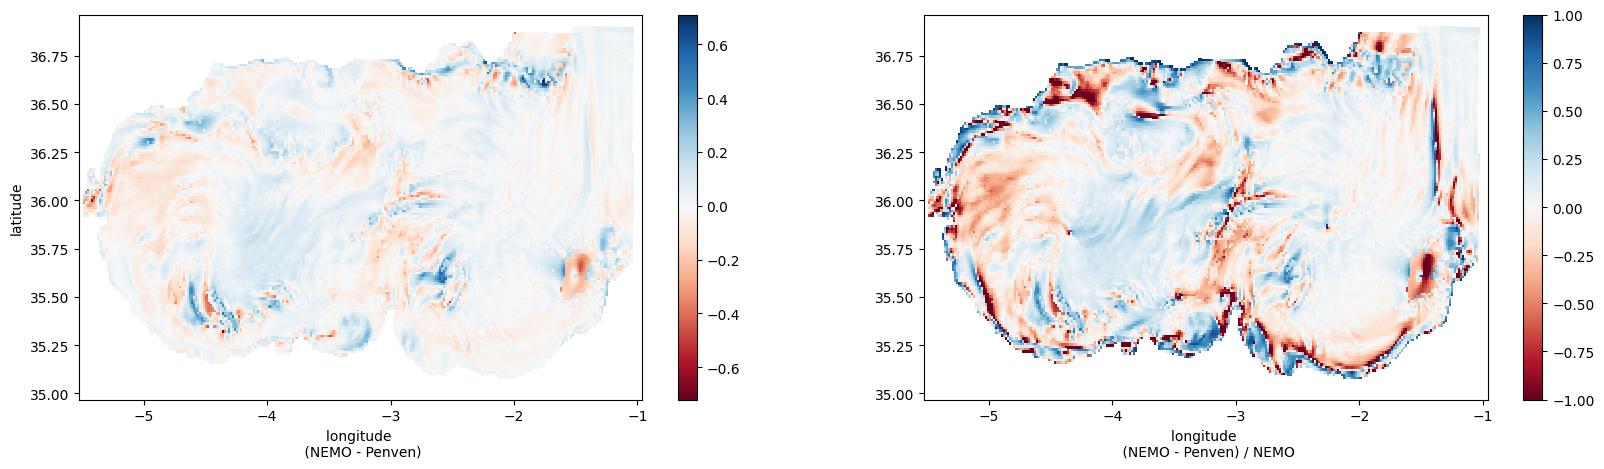

In [19]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_xlabel("longitude \n (NEMO)")
ax2.set_xlabel("longitude \n (Penven)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, np.sqrt(uvel**2 + vvel**2), shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax1)
ax1.quiver(lon[::quiver_step, ::quiver_step], lat[::quiver_step, ::quiver_step], 
           uvel[::quiver_step, ::quiver_step], vvel[::quiver_step, ::quiver_step])
im = ax2.pcolormesh(lon, lat, np.sqrt(u_penven**2 + v_penven**2), shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax2)
ax2.quiver(lon[::quiver_step, ::quiver_step], lat[::quiver_step, ::quiver_step], 
           u_penven[::quiver_step, ::quiver_step], v_penven[::quiver_step, ::quiver_step])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_xlabel("longitude \n (NEMO - Penven)")
ax2.set_xlabel("longitude \n (NEMO - Penven) / NEMO")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, np.sqrt(uvel**2 + vvel**2) - np.sqrt(u_penven**2 + v_penven**2), cmap="RdBu", shading="auto")
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, (np.sqrt(uvel**2 + vvel**2) - np.sqrt(u_penven**2 + v_penven**2)) / np.sqrt(uvel**2 + vvel**2), cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

## Ioannou method

We use the same function, but with the argument `method="ioannou"`. 

In [20]:
u_ioannou, v_ioannou = cyclogeostrophy(u_geos, v_geos, dx_u, dx_v, dy_u, dy_v, coriolis_factor_u, coriolis_factor_v, method="ioannou")

 12%|█▏        | 12/100 [00:00<00:00, 111.73it/s]/home/bertrava/projects/jaxparrow/jaxparrow/tools/tools.py:214: RuntimeWarning: overflow encountered in multiply
  adv_v = u_adv * dvdx + v_adv * dvdy  # u points
/home/bertrava/projects/jaxparrow/jaxparrow/tools/tools.py:214: RuntimeWarning: invalid value encountered in add
  adv_v = u_adv * dvdx + v_adv * dvdy  # u points
/home/bertrava/projects/jaxparrow/jaxparrow/tools/tools.py:180: RuntimeWarning: overflow encountered in multiply
  adv_u = u_adv * dudx + v_adv * dudy  # v points
/home/bertrava/projects/jaxparrow/jaxparrow/tools/tools.py:180: RuntimeWarning: invalid value encountered in add
  adv_u = u_adv * dudx + v_adv * dudy  # v points
 24%|██▍       | 24/100 [00:00<00:00, 111.70it/s]/home/bertrava/projects/jaxparrow/jaxparrow/tools/tools.py:214: RuntimeWarning: overflow encountered in add
  adv_v = u_adv * dvdx + v_adv * dvdy  # u points
/home/bertrava/projects/jaxparrow/jaxparrow/cyclogeostrophy.py:169: RuntimeWarning: overflow

In [21]:
u_ioannou = ma.masked_array(u_ioannou, mask_u)
v_ioannou = ma.masked_array(v_ioannou, mask_v)

#### Comparison to NEMO's velocities

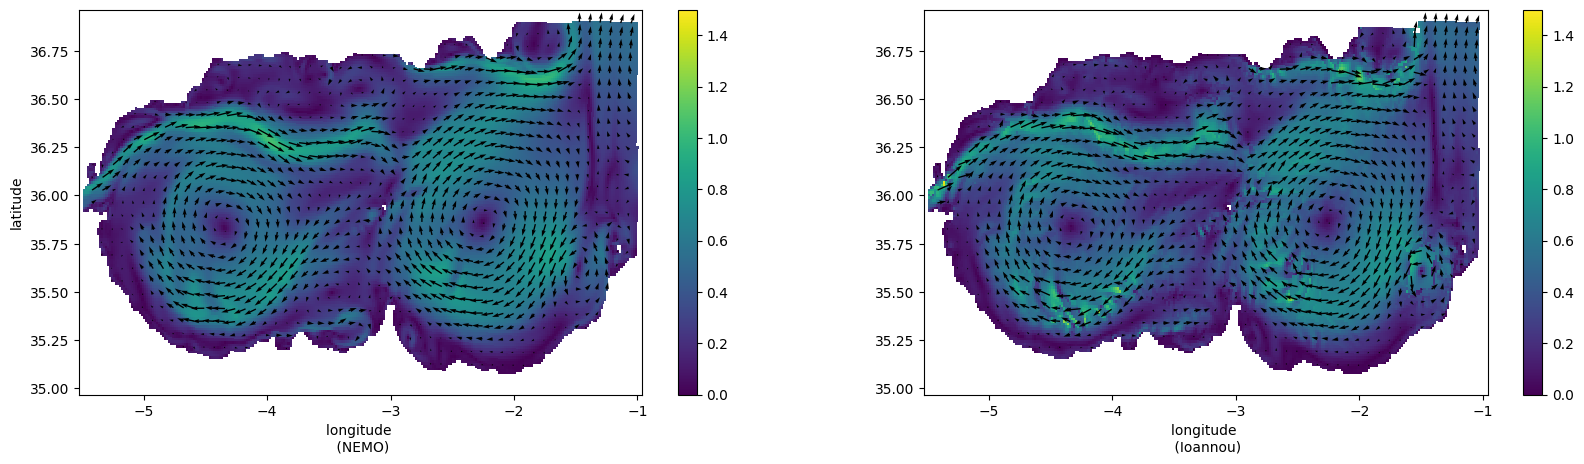

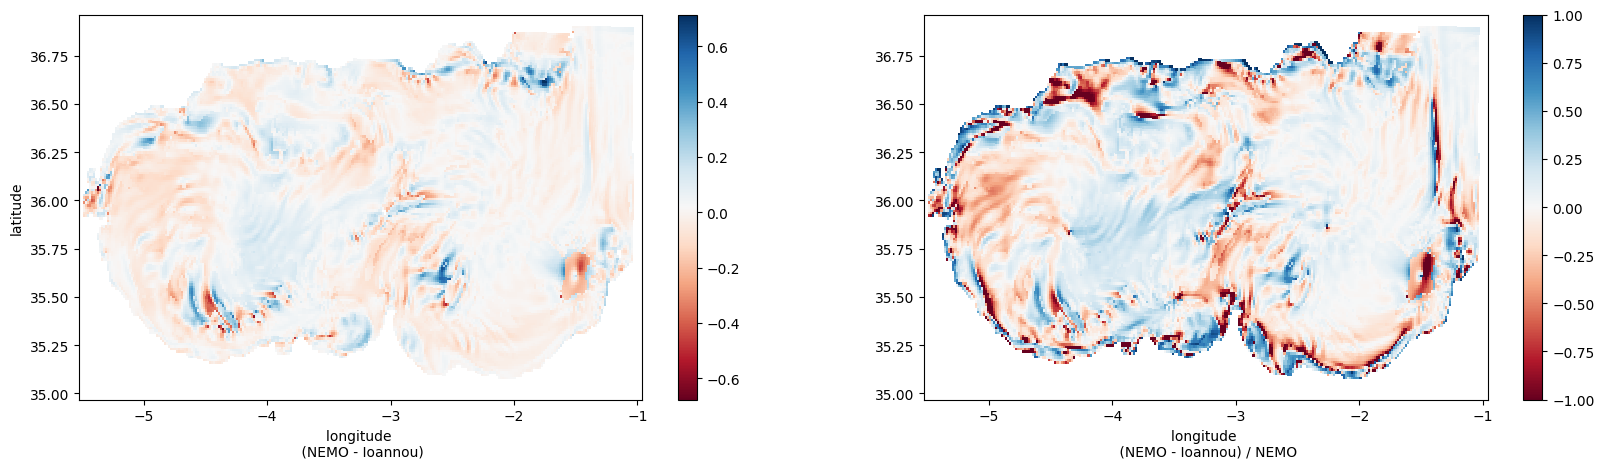

In [22]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_xlabel("longitude \n (NEMO)")
ax2.set_xlabel("longitude \n (Ioannou)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, np.sqrt(uvel**2 + vvel**2), shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax1)
ax1.quiver(lon[::quiver_step, ::quiver_step], lat[::quiver_step, ::quiver_step], 
           uvel[::quiver_step, ::quiver_step], vvel[::quiver_step, ::quiver_step])
im = ax2.pcolormesh(lon, lat, np.sqrt(u_ioannou**2 + v_ioannou**2), shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax2)
ax2.quiver(lon[::quiver_step, ::quiver_step], lat[::quiver_step, ::quiver_step], 
           u_ioannou[::quiver_step, ::quiver_step], v_ioannou[::quiver_step, ::quiver_step])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_xlabel("longitude \n (NEMO - Ioannou)")
ax2.set_xlabel("longitude \n (NEMO - Ioannou) / NEMO")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, np.sqrt(uvel**2 + vvel**2) - np.sqrt(u_ioannou**2 + v_ioannou**2), cmap="RdBu", shading="auto")
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, (np.sqrt(uvel**2 + vvel**2) - np.sqrt(u_ioannou**2 + v_ioannou**2)) / np.sqrt(uvel**2 + vvel**2), cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

#### Comparison to Penven velocities

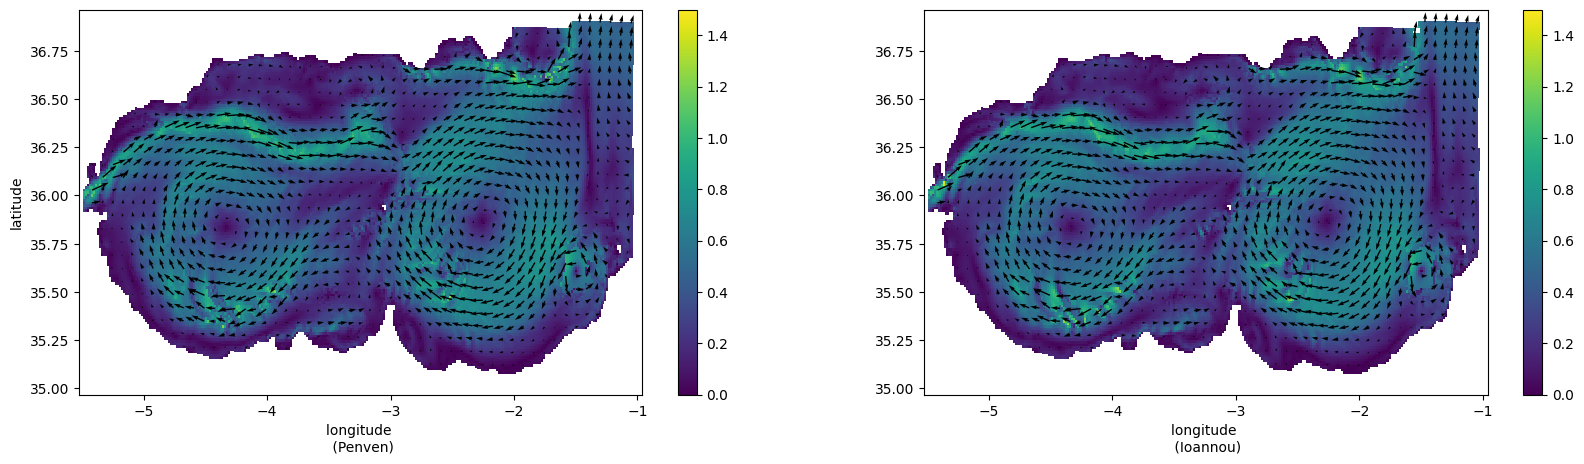

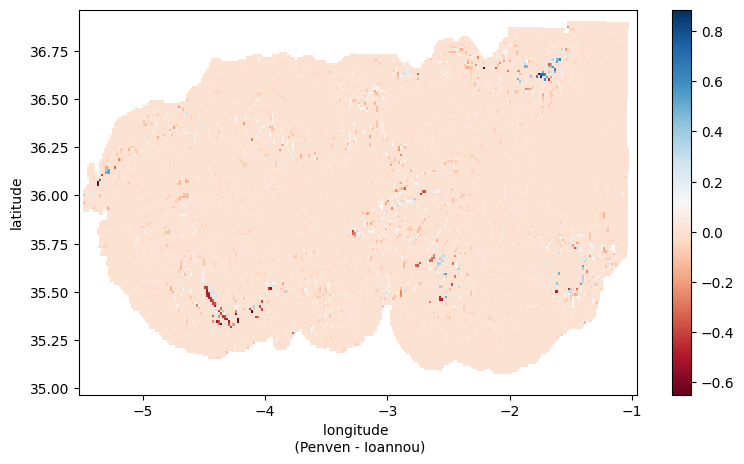

In [23]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_xlabel("longitude \n (Penven)")
ax2.set_xlabel("longitude \n (Ioannou)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, np.sqrt(u_penven**2 + v_penven**2), shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax1)
ax1.quiver(lon[::quiver_step, ::quiver_step], lat[::quiver_step, ::quiver_step], 
           u_penven[::quiver_step, ::quiver_step], v_penven[::quiver_step, ::quiver_step])
im = ax2.pcolormesh(lon, lat, np.sqrt(u_ioannou**2 + v_ioannou**2), shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax2)
ax2.quiver(lon[::quiver_step, ::quiver_step], lat[::quiver_step, ::quiver_step], 
           u_ioannou[::quiver_step, ::quiver_step], v_ioannou[::quiver_step, ::quiver_step])

_, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.set_xlabel("longitude \n (Penven - Ioannou)")
ax.set_ylabel("latitude")
im = ax.pcolormesh(lon, lat, np.sqrt(u_penven**2 + v_penven**2) - np.sqrt(u_ioannou**2 + v_ioannou**2), cmap="RdBu", shading="auto")
plt.colorbar(im, ax=ax)